<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Увоз библиотека</h2>
</div>

In [36]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Учитавање података и модела</h2>
</div>

In [38]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [39]:
# Setup directory paths to train and test images
train_dir = 'EPT100/train_512'
val_dir = 'EPT100/val_512'
test_dir = 'EPT100/test_512'

In [40]:
train_data = datasets.ImageFolder(train_dir)
train_data

Dataset ImageFolder
    Number of datapoints: 8603
    Root location: EPT100/train_512

In [41]:
pretrained_deit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True).to(device)
for parameter in pretrained_deit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = train_data.classes
set_seeds(33)

n_inputs = pretrained_deit.head.in_features

print(n_inputs)
pretrained_deit.head = nn.Linear(in_features=n_inputs, out_features=len(class_names)).to(device)

Using cache found in C:\Users\Stevan/.cache\torch\hub\facebookresearch_deit_main


768


In [42]:
from torchinfo import summary
summary(model=pretrained_deit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [32, 3, 224, 224]    [32, 100]            152,064              Partial
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    └─Conv2d (proj)                     [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    └─Identity (norm)                   [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout (pos_drop)                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (patch_drop)                  [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (norm_pre)                    [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (blocks)                    [32, 197, 768]       [32, 197, 768]       --                   False
│    └─Block (0)

In [43]:
import os

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str, test_dir: str, val_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  val_data = datasets.ImageFolder(val_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [44]:
pretrained_deit_transforms = transforms.Compose([
    transforms.Resize(246, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Setup dataloaders
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     val_dir=val_dir,
                                                                                                     transform=pretrained_deit_transforms,
                                                                                                     batch_size=32)

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тренирање модела</h2>
</div>

In [45]:
from going_modular.going_modular import engine
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_deit.parameters(), 
                             lr=3e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained Deit feature extractor model
set_seeds(33)
pretrained_deit_results, model = engine.train(model=pretrained_deit,
                                      train_dataloader=train_dataloader_pretrained,
                                      val_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=60,
                                      patience=15,
                                      lr_patience=12,
                                      best_model_path='Results/Models/Deit_base_transfer_learning_60_15_12.pth',
                                      device=device)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9118 | train_acc: 0.8066 | val_loss: 0.3366 | val_acc: 0.9222 | learning_rate: 0.003000
Epoch: 2 | train_loss: 0.1627 | train_acc: 0.9712 | val_loss: 0.2136 | val_acc: 0.9499 | learning_rate: 0.003000
Epoch: 3 | train_loss: 0.0808 | train_acc: 0.9904 | val_loss: 0.1893 | val_acc: 0.9528 | learning_rate: 0.003000
Epoch: 4 | train_loss: 0.0472 | train_acc: 0.9957 | val_loss: 0.1605 | val_acc: 0.9587 | learning_rate: 0.003000
Epoch: 5 | train_loss: 0.0308 | train_acc: 0.9984 | val_loss: 0.1522 | val_acc: 0.9589 | learning_rate: 0.003000
Epoch: 6 | train_loss: 0.0211 | train_acc: 0.9995 | val_loss: 0.1390 | val_acc: 0.9640 | learning_rate: 0.003000
Epoch: 7 | train_loss: 0.0159 | train_acc: 0.9997 | val_loss: 0.1352 | val_acc: 0.9602 | learning_rate: 0.003000
Epoch: 8 | train_loss: 0.0127 | train_acc: 0.9993 | val_loss: 0.1344 | val_acc: 0.9634 | learning_rate: 0.003000
Epoch: 9 | train_loss: 0.0103 | train_acc: 0.9994 | val_loss: 0.1235 | val_acc: 0.9673 | learnin

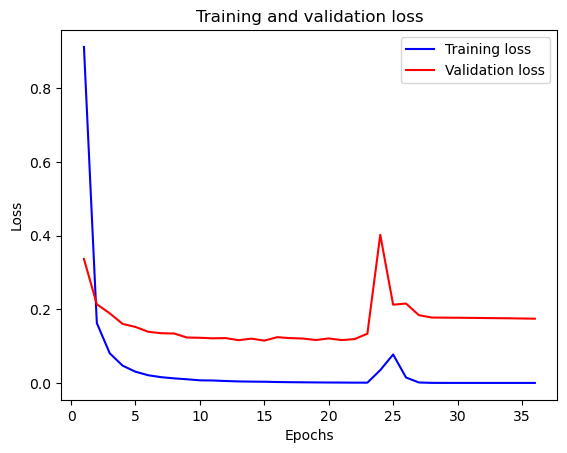

In [46]:
epochs = range(1, len(pretrained_deit_results['train_loss']) + 1)

plt.plot(epochs, pretrained_deit_results['train_loss'], 'b-', label='Training loss')
plt.plot(epochs, pretrained_deit_results['val_loss'], 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

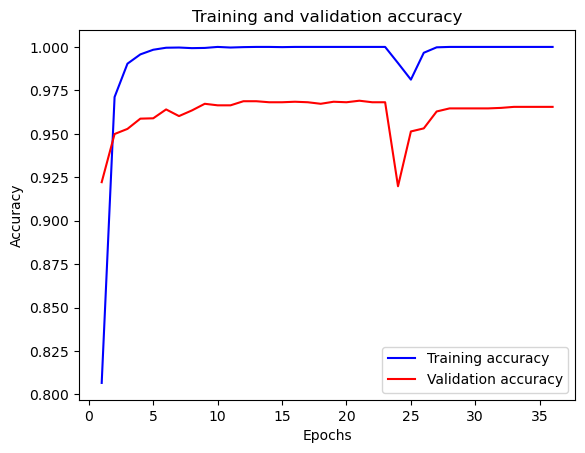

In [47]:
epochs = range(1, len(pretrained_deit_results['train_acc']) + 1)

plt.plot(epochs, pretrained_deit_results['train_acc'], 'b-', label='Training accuracy')
plt.plot(epochs, pretrained_deit_results['val_acc'], 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
loaded_model = torch.load('Results/Models/Deit_base_transfer_learning_60_15_12.pth')

# Switch the model to evaluation mode
loaded_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тестирање модела</h2>
</div>

In [49]:
set_seeds(33)
test_loss, test_acc = engine.test(model=loaded_model,
                           test_dataloader=test_dataloader_pretrained,
                           loss_fn=loss_fn,
                           device=device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1079, Test Accuracy: 0.9689


In [50]:
import pickle

# Save the pretrained_vit_results dictionary to disk
with open('Results/Training results/pretrained_deit_base_results.pkl', 'wb') as f:
    pickle.dump(pretrained_deit_results, f)

In [51]:
with open('Results/Training results/pretrained_deit_base_results.pkl', 'rb') as f:
    loaded_pretrained_deit_results = pickle.load(f)